In [ ]:
import cv2 as cv
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt

def grid_lines(image, grid_shape, color=(0, 255, 0), thickness=1):
    """
    Draws a grid on the given image.

    Parameters:
    - image: The input image on which to draw the grid.
    - grid_shape: A tuple (rows, cols) specifying the number of grid cells.
    - color: The color of the grid lines (default is green).
    - thickness: The thickness of the grid lines (default is 1).

    Returns:
    - The image with the grid drawn on it.
    """
    img_height, img_width = image.shape[:2]
    rows, cols = grid_shape

    # Calculate the spacing between lines
    row_height = img_height // rows
    col_width = img_width // cols

    # Draw horizontal lines
    for i in range(1, rows):
        y = i * row_height
        cv.line(image, (0, y), (img_width, y), color, thickness)

    # Draw vertical lines
    for j in range(1, cols):
        x = j * col_width
        cv.line(image, (x, 0), (x, img_height), color, thickness)

    return image

In [4]:
image = r"C:\Users\dolap\OneDrive\Documents\DOLAPO\data-analysis\photoquadrats_analysis\img\sample_img.JPG"

In [5]:
img = cv.imread(image)

In [11]:
grid_img = grid_lines(img.copy(), (4, 4), color=(255, 0, 0), thickness=2)

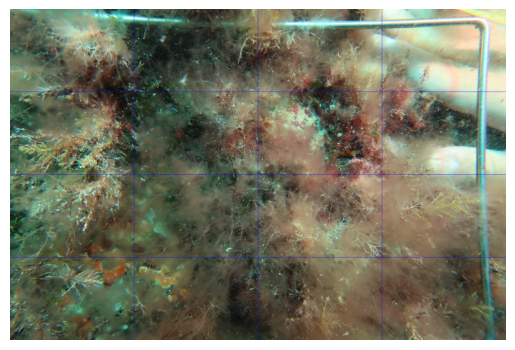

In [ ]:
# visualise the image with grid in notebook

plt.imshow(cv.cvtColor(grid_img, cv.COLOR_BGR2RGB)) 
plt.axis('off')
plt.show()

### Grid Based segmentation and classification

In [ ]:
def calculate_segmentation_per_grid(image, grid_shape, masks):
    """
    Calculate the area of segmentation in each grid cell.

    Parameters:
    - image: The input image.
    - grid_shape: A tuple (rows, cols) specifying the number of grid cells.
    - masks: List of segmentation masks from YOLOv8 (binary masks).

    Returns:
    - A dictionary with grid cell coordinates as keys and segmentation areas as values.
    """
    img_height, img_width = image.shape[:2]
    rows, cols = grid_shape

    # Calculate the spacing between lines
    row_height = img_height // rows
    col_width = img_width // cols

    # Initialize the grid areas dictionary
    grid_areas = {}
    for i in range(rows):
        for j in range(cols):
            grid_areas[(i, j)] = 0

    # Combine all masks into a single mask
    combined_mask = np.zeros((img_height, img_width), dtype=np.uint8)
    for mask in masks:
        combined_mask = cv.bitwise_or(combined_mask, mask.astype(np.uint8) * 255)

    # Calculate area per grid cell
    for i in range(rows):
        for j in range(cols):
            # Define the region of interest for this grid cell
            y_start = i * row_height
            y_end = (i + 1) * row_height
            x_start = j * col_width
            x_end = (j + 1) * col_width

            # Extract the mask region for this grid cell
            grid_mask = combined_mask[y_start:y_end, x_start:x_end]

            # Count the segmented pixels (non-zero pixels)
            area = np.sum(grid_mask > 0)
            grid_areas[(i, j)] = area

    return grid_areas

In [ ]:
# Load image and model
image_path = image
img = cv.imread(image_path)

# Load YOLOv8 segmentation model
model = YOLO("yolov8n-seg.pt")  # Use yolov8n-seg, yolov8m-seg, etc.

# Run inference
results = model(img)

# Extract masks
masks = []
if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()

# Calculate segmentation area per grid
grid_shape = (4, 4)
grid_areas = calculate_segmentation_per_grid(img, grid_shape, masks)

# Print results
print("Segmentation area per grid cell (in pixels):")
for (row, col), area in sorted(grid_areas.items()):
    print(f"Grid ({row}, {col}): {area} pixels")

# Visualize
grid_img = grid_lines(img.copy(), grid_shape, color=(255, 0, 0), thickness=2)
plt.imshow(cv.cvtColor(grid_img, cv.COLOR_BGR2RGB))
plt.title("Image with Grid")
plt.axis("off")
plt.show()